In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import lightgbm as lgb
import shap


In [2]:
import sys
sys.path.insert(0, '../milestone-04')
from utils import load_from_csv

import timeseries_utils
import utils_lgbm

In [3]:
# Import the tables of the data set as dataframes.
# Choose random or uniform sampling
uniform = False

if not uniform:
    DATA_DIR = '../milestone-04/data' 

    # You can use the nrows=X argument in pd.read_csv to truncate your data
    users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col=0)
    events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col=0)
    subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)
    mastery_df = load_from_csv('../milestone-04/dataframe.csv')
else:
    DATA_DIR = './data_uniform' 
    users = pd.read_csv('{}/users_uniform_sample.csv'.format(DATA_DIR),index_col=1)
    events = pd.read_csv('{}/events_uniform_sample.csv'.format(DATA_DIR), index_col=1)
    subtasks = pd.read_csv('{}/subtasks_uniform_sample.csv'.format(DATA_DIR), index_col=1)
    mastery_df = load_from_csv('dataframe_uniform.csv')

In [30]:
index = ['event_id','user_id']
cat_features = ['mode_event', 'game_name','number_range','skill_id', 'type_subtask', 'country']
cat_features_withnulls = [ 'destination', 'multiplier','operator','representation', 'solutionRepresentation', 'solveMode']
date_features = ['date','Year', 'Week', 'Day','week','year_week']
bool_feature = ['correct']

In [31]:
full_df = timeseries_utils.create_timeseries(users, events, subtasks)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
full_df = full_df[index + cat_features + date_features + bool_feature]

In [34]:
full_df

,event_id,user_id,mode_event,game_name,number_range,skill_id,type_subtask,country,date,Year,Week,Day,week,year_week,correct
0,0,1,NORMAL,Subitizing,R10,1.0,ConciseSubitizingTaskDescription,CH,2022-11-02 08:39:12.355000+00:00,2022,44,3,1,415,1
1,0,1,NORMAL,Subitizing,R10,1.0,ConciseTimeoutDescription,CH,2022-11-02 08:39:12.355000+00:00,2022,44,3,1,415,1
2,1,1,NORMAL,Conversion,R10,4.0,ConciseConversionTaskDescription,CH,2022-11-11 10:26:27.893000+00:00,2022,45,5,2,416,1
3,2,1,NORMAL,Conversion,R10,7.0,ConciseConversionTaskDescription,CH,2022-11-18 10:34:01.044000+00:00,2022,46,5,3,417,1
4,3,1,NORMAL,Landing,R10,19.0,ConciseLandingTaskDescription,CH,2022-11-25 10:32:43.428000+00:00,2022,47,5,4,418,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55469,37415,998,END_OF_NR,Landing,R100,111.0,ConciseLandingTaskDescription,CH,2021-01-06 14:14:36.824000+00:00,2021,1,3,22,319,1
55470,37417,1000,NORMAL,Subitizing,R10,1.0,ConciseSubitizingTaskDescription,BE,2019-09-30 10:04:31.264000+00:00,2019,40,1,1,252,0
55471,37417,1000,NORMAL,Subitizing,R10,1.0,ConciseTimeoutDescription,BE,2019-09-30 10:04:31.264000+00:00,2019,40,1,1,252,1
55472,37418,1000,NORMAL,Conversion,R10,3.0,ConciseConversionTaskDescription,BE,2020-01-20 10:02:02.957000+00:00,2020,4,1,18,269,1


In [35]:
# Create a feature that represents the student's overall cumulative accuracy per skill
cumulative_percent_correct = full_df.groupby(['user_id','skill_id'],sort=False)['correct'].expanding(1).mean().reset_index().drop(columns=['user_id','skill_id']).rename(columns={'correct':'cumulative_percent_correct'})
full_df = full_df.merge(cumulative_percent_correct, left_index=True, right_on='level_2', how='left')

# Create a feature that represent's a skill's overall cumulative correctness for all students
df_skills_mean = full_df.groupby(["skill_id", "year_week"]).mean()
df_skills_mean["skill_cumulative_percent_correct"] = df_skills_mean['correct'].expanding(1).mean()
df_skills_mean = df_skills_mean.reset_index()[["skill_id","year_week","skill_cumulative_percent_correct"]]
full_df = full_df.merge(df_skills_mean, on=["skill_id","year_week"], how='left')

In [36]:
df = full_df.merge(mastery_df, how='left', on=['week','user_id','game_name'])
df = df[~ df['mastery_level'].isna()]

In [37]:
# LGBM only accepts int, bool and float
for col in cat_features:
    # Convert categories into ints
    df[col] = df[col].astype('category')
df['week'] = df['week'].astype('int32')
df[bool_feature] = df[bool_feature].astype('bool')

In [38]:
import importlib
importlib.reload(timeseries_utils)

<module 'timeseries_utils' from '/home/milestone-4-calcularis-crusaders/project/milestone-05/timeseries_utils.py'>

In [39]:
generated_features = ['cumulative_percent_correct', 'skill_cumulative_percent_correct']
features = index + cat_features + generated_features + ['week']
target_feature = ['mastery_level'] # or 'mastery_level_diff'

if not uniform: 
    lgb_train, lgb_eval, lgb_test = utils_lgbm.create_train_test_split(df, features, target_feature, cat_features)
else: 
    lgb_train, lgb_eval, lgb_test = timeseries_utils.create_uniform_train_test_split(df, features, target_feature, cat_features, users)

In [56]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

In [69]:
params = {'objective': 'regression',
      'metric': ['mse','rmse','mape'],
      'seed': 0,
      'learning_rate': 0.1, #default
      "boosting_type": "gbdt" #default
      # 'num_leaves': 200,
      # 'feature_fraction': 0.75,
      # 'bagging_freq': 10,
      # 'bagging_fraction': 0.80
     }
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8,
    keep_training_booster=True,
    feval=lgbm_smape
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.402083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1375
[LightGBM] [Info] Number of data points in the train set: 24861, number of used features: 11
[LightGBM] [Info] Start training from score 0.208729
Training until validation scores don't improve for 8 rounds
Early stopping, best iteration is:
[21]	training's l2: 0.00899225	training's rmse: 0.0948275	training's mape: 0.0674617	training's SMAPE: 46.0423	valid_1's l2: 0.0146152	valid_1's rmse: 0.120894	valid_1's mape: 0.0824248	valid_1's SMAPE: 51.7004


In [70]:
overall_auc = model.eval(lgb_test, 'mape')
print(f"Overall MAPE for test data is {overall_auc[0][2]}")

Overall MAPE for test data is 0.016405546315960234


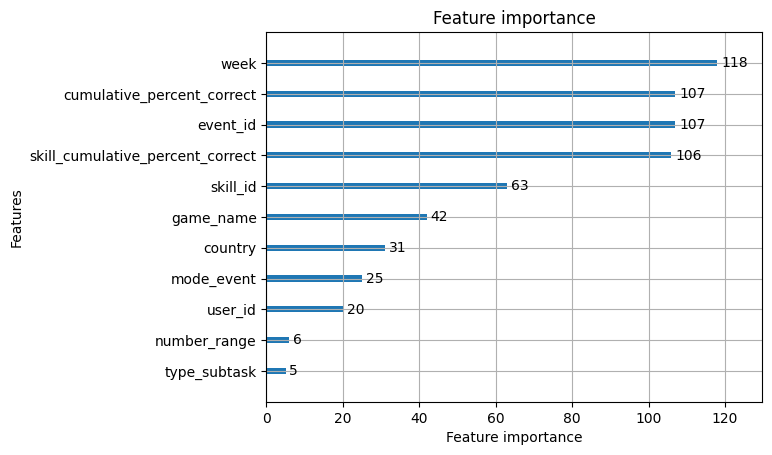

In [71]:
lgb.plot_importance(model)
plt.show()

In [72]:
# TODO fix this
test = df.query('user_id >= 800')[features]
y_test = df.query('user_id >= 800')[target_feature]

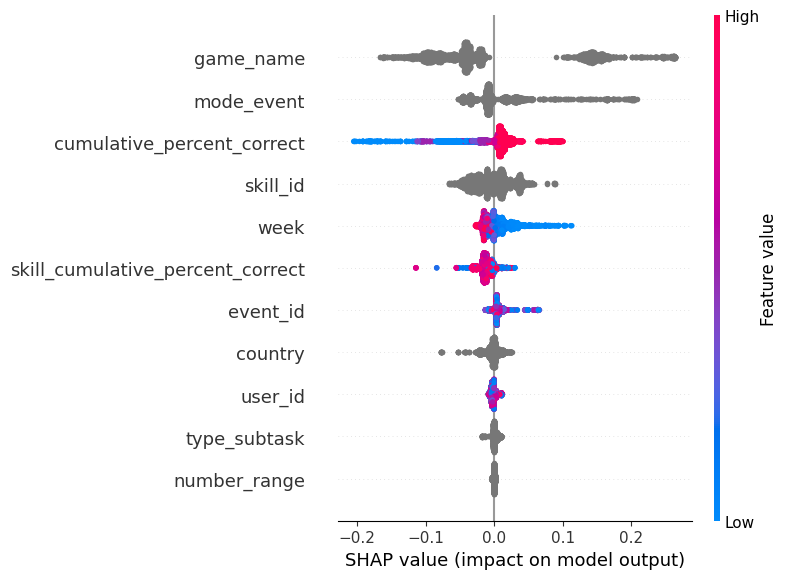

In [73]:
shap_values = shap.TreeExplainer(model).shap_values(test)
shap.summary_plot(shap_values, test)

In [ ]:
# train_user_ids = []
# valid_user_ids = []
# test_user_ids = []
# for c in users.country.unique():
#     train_user_ids.extend(list(users.query(f'country == "{c}"').index[:150]))
#     valid_user_ids.extend(list(users.query(f'country == "{c}"').index[150:200]))
#     test_user_ids.extend(list(users.query(f'country == "{c}"').index[200:]))

# train_df = df[df["user_id"].isin(train_user_ids)]
# valid_df = df[df["user_id"].isin(valid_user_ids)]
# test_df = df[df["user_id"].isin(test_user_ids)]

# train = train_df[features]
# y_train = train_df[target_feature]
# val = valid_df[features]
# y_val = valid_df[target_feature]
# test = test_df[features]
# y_test = test_df[target_feature]

(array([1387., 1346.,  854.,  470.,   99.,   17.,   20.,   10.,   40.,
          64.]),
 array([0.05255198, 0.13037318, 0.20819437, 0.28601557, 0.36383677,
        0.44165797, 0.51947917, 0.59730037, 0.67512157, 0.75294277,
        0.83076397]),
 <BarContainer object of 10 artists>)

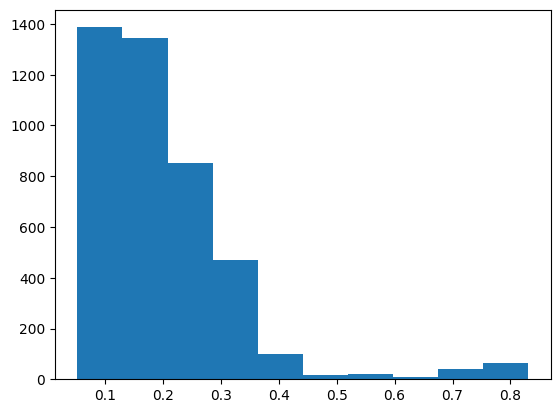

In [74]:
pred = model.predict(test)
plt.hist(pred)

(array([1258., 1279.,  868.,  325.,  191.,  221.,   83.,   14.,    4.,
          64.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

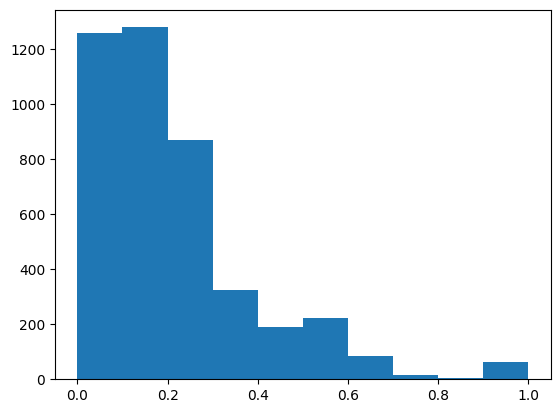

In [75]:
plt.hist(y_test[target_feature])

In [76]:
y_pred_test = model.predict(test, num_iteration=model.best_iteration)


In [77]:
smape(y_pred_test, y_test['mastery_level'])

52.6507163515474

In [89]:
binary_mastered_pred = y_pred_test > 0.5
binary_mastered = y_test['mastery_level'] > 0.5

In [93]:
test['country']

44530    CH
44531    CH
44532    CH
44533    CH
44534    CH
         ..
50083    CH
50084    CH
50085    CH
50086    CH
50087    CH
Name: country, Length: 4307, dtype: category
Categories (12, object): ['AT', 'CA', 'CH', 'DE', ..., 'NO', 'RU', 'SE', 'US']

In [94]:
fairness_df = pd.DataFrame({"score": binary_mastered_pred, "label_value":binary_mastered, "country":test['country']})

In [96]:
fairness_df.to_csv("fairness.csv", index=False)